# Examples on how to plot the images 

Never mind the extra inputs. I did a sneaky copy paste.

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from datetime import datetime
from typing import Sequence
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
torch.manual_seed(123)
# We use torch.double to get the same results as Pytorch
torch.set_default_dtype(torch.double)

# run the training on CPU
device = torch.device('cpu')

### Localization

For the data used for localization. These images have only one digit each.

In [2]:
def load_MNIST_loc(data_path='../data/', preprocessor=None):
    # loading the data from preprocessed data sets:
    
    data_train = torch.load(data_path + 'localization_train.pt')
    data_val = torch.load(data_path + 'localization_val.pt')
    data_test = torch.load(data_path + 'localization_test.pt')
    
    
    print("Size of the train dataset:        ", len(data_train))
    
    return data_train

In [3]:
data_train_loc = load_MNIST_loc('../../project2/data/')

Size of the train dataset:         54000


Select four random images in the training set and plot them to see how they look.

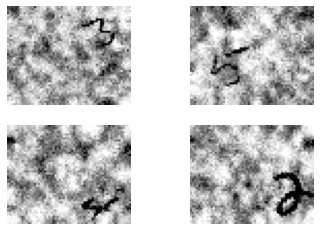

In [15]:
i1, l1 = data_train_loc[1]
pix1 = i1.reshape((48, 60)) # get on new shape for imshow

i2, l2 = data_train_loc[1000]
pix2 = i2.reshape((48, 60)) # get on new shape for imshow

i3, l3 = data_train_loc[5000]
pix3 = i3.reshape((48, 60)) # get on new shape for imshow

i4, l4 = data_train_loc[550]
pix4 = i4.reshape((48, 60)) # get on new shape for imshow

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(pix1, cmap='Greys')
axs[0,0].axis('off');

axs[0,1].imshow(pix2, cmap='Greys')
axs[0,1].axis('off');

axs[1,0].imshow(pix3, cmap='Greys')
axs[1,0].axis('off');

axs[1,1].imshow(pix4, cmap='Greys')
axs[1,1].axis('off');

The true label output is the following (*p$_c$, x, y, w, h, c$_1$, · · · , c$_C$*). For the localization data $C=1$ as we only have one number in each image, but the detection data can have $C>1$. See further down.

In [5]:
l1

tensor([1.0000, 0.7250, 0.2500, 0.2833, 0.2917, 3.0000], dtype=torch.float32)

For the bounding boxes we get the following information:

The 4 components *x, y, h, w* define the bounding box (bb). (*x, y*) represents the coordinates of the center of the bb, with both *x* and *y* between 0 and 1. The point (0, 0) is the top left corner of the image and (1, 1) the bottom right corner. *w* and *h* respectively stand for width and height of the bb, they are also between 0 and 1. I found a method for drawing bb [online](https://www.programcreek.com/python/?CodeExample=draw+bounding+box) and modified it to correct the coordinates to fit the image grid. I also made a method to make the bb coordinates in the torch tensors readable by the function to draw the boxes:

In [6]:
def draw_bounding_box(pane, rect_coordinates, fig=None, axs=None):
    """
    pane : img or list[img]
        60x48 images
        
    """
    # Show bounding boxes given image and array of bb coordinates (x,y,w,h)

    # Create figure and axes if not given already
    if (fig == None) and (axs == None):
        fig, axs = plt.subplots(1)
        if type(pane) == list:
            raise RuntimeError('You must give multiple axes to draw the images on!')
        else:
            axs.imshow(pane, cmap = 'Greys')
            axs.axis('off')
        
    # Display the image(s)
    if type(pane) == list:
        if len(pane) != len(axs):
            raise RuntimeError('Number of images and axes do not match!')
        for i in range(len(pane)):
            axs[i].imshow(pane[i], cmap = 'Greys')
            axs[i].axis('off')
    
    if type(pane) == list:
        if len(pane) != len(rect_coordinates):
            raise RuntimeError('You must give as many bounding boxes as there are images!')
        for i in range(len(rect_coordinates)):
            for e in rect_coordinates[i]:
                (x, y, w, h) = e

                # scaling bb coordinates to fit coordinates on image
                w = w*60
                h = h*48

                # moves center coordinates to top left corner
                x = x*60 - w/2 
                y = y*48 - h/2 

                # drawing the bounding boxes on image
                rect = matplotlib.patches.Rectangle((x,y), w, h, linewidth = 2, edgecolor='cornflowerblue', facecolor = 'none')
                axs[i].add_patch(rect)
    else:
        # Create a Rectangle patch(es)
        for e in rect_coordinates:
            (x, y, w, h) = e

            # scaling bb coordinates to fit coordinates on image
            w = w*60
            h = h*48

            # moves center coordinates to top left corner
            x = x*60 - w/2 
            y = y*48 - h/2 

            # drawing the bounding boxes on image
            rect = matplotlib.patches.Rectangle((x,y), w, h, linewidth = 2, edgecolor='cornflowerblue', facecolor = 'none')
            axs.add_patch(rect)

        
def translate_from_torch(torches):
    # Translate torch tensors to arrays to be used in draw_bounding_box()
    
    # for the entries that are only one torch tensor (localization)
    if type(torches) != list:
        # we only have one entry
        newrect = np.zeros((1,4))
        rect = torches[1:5].cpu().detach().numpy()
        for i in range(len(rect)):
            entry = rect[i]
            newrect[0][i] = entry.item()
            
        return newrect
    
    # for the list of torch tensors (detection)
    else:
        newrects = np.zeros((len(torches), 4))
        for i in range(len(torches)):
            rect = torches[i][1:5].cpu().detach().numpy()
            for k in range(len(rect)):
                entry = rect[k]
                newrects[i][k] = entry.item()
                
        return newrects

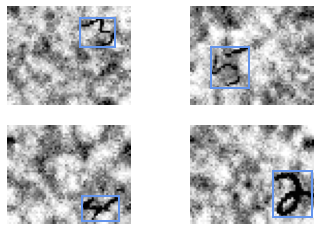

In [7]:
fig, axs = plt.subplots(2,2)
imgs = [pix1, pix2, pix3, pix4]
labs = [translate_from_torch(l1),translate_from_torch(l2),translate_from_torch(l3),translate_from_torch(l4)]
draw_bounding_box(imgs, labs, fig, axs.flatten())

The function also allows for drawing just draw one image with bounding boxes:

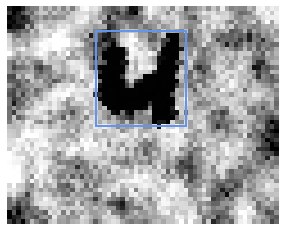

In [8]:
imgnr = 1002
img, label = data_train_loc[imgnr]
pix = img.reshape((48, 60))

draw_bounding_box(pix, translate_from_torch(label))

### Detection

In object detection, multiple digits can be found in one image:

In [9]:
def load_MNIST_det(data_path='../data/', preprocessor=None):
    
    # vi har ferdig oppdeling
    data_train = torch.load(data_path + 'detection_train.pt')
    data_val = torch.load(data_path + 'detection_val.pt')
    data_test = torch.load(data_path + 'detection_test.pt')
    y_train = torch.load(data_path + 'list_y_true_train.pt')

    print("Size of the train dataset:        ", len(data_train))
    
    return data_train, y_train

In [10]:
data_train_det, labels_det = load_MNIST_det('../../project2/data/')

Size of the train dataset:         6886


We select four random images and plot them. Notice that we have pre-made lists of the true labels. The length is the same as $C$ (number of objects).

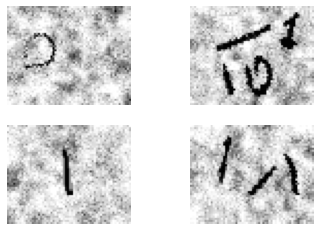

In [16]:
img1, label1 = data_train_det[5]
true_labels1 = labels_det[5]
pixels1 = img1.reshape((48, 60)) # get on new shape for imshow


img2, label2 = data_train_det[1000]
true_labels2 = labels_det[1000]
pixels2 = img2.reshape((48, 60)) # get on new shape for imshow


img3, label3 = data_train_det[6580]
true_labels3 = labels_det[6580]
pixels3 = img3.reshape((48, 60)) # get on new shape for imshow


img4, label4 = data_train_det[550]
true_labels4 = labels_det[550]
pixels4 = img4.reshape((48, 60)) # get on new shape for imshow

# plot 
fig, axss = plt.subplots(2, 2)
axss[0,0].imshow(pixels1, cmap='Greys')
axss[0,0].axis('off');

axss[0,1].imshow(pixels2, cmap='Greys')
axss[0,1].axis('off');

axss[1,0].imshow(pixels3, cmap='Greys')
axss[1,0].axis('off');

axss[1,1].imshow(pixels4, cmap='Greys')
axss[1,1].axis('off');

The previous method is generalized to also plot the bounding boxes for multiple digits in one image:

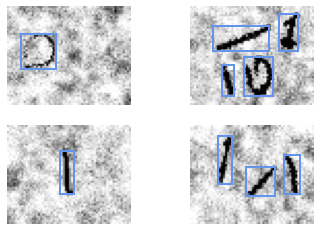

In [18]:
fig, axs = plt.subplots(2,2)

imgs = [pixels1, pixels2, pixels3, pixels4]
labs = [translate_from_torch(true_labels1),translate_from_torch(true_labels2),translate_from_torch(true_labels3),translate_from_torch(true_labels4)]

# then draw them
draw_bounding_box(imgs, labs, fig, axs.flatten())


You can also just draw one image:

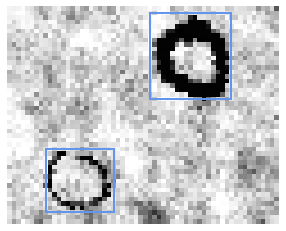

In [13]:
imgnr = 1002
img, _ = data_train_det[imgnr]
true_labels = labels_det[imgnr]

# get on shape for imshow
pix = img.reshape((48, 60))

draw_bounding_box(pix, translate_from_torch(true_labels))